# Ultility and Preparation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
import sys
sys.path.append('..')

from src.dataset import SeaTurtleDataset

## A. Reduce Dataset size while implement models

In [3]:
INDIVIDUALS = 10
TRAIN_ENCOUNTERS = 2
EVAL_ENCOUNTERS = 1
TEST_ENCOUNTERS = 1

In [4]:
df = pd.read_csv('../data/metadata_splits.csv')
df.head()

,id,width,height,file_name,timestamp,identity,date,year,split_closed,split_closed_random,split_open,clarity
0,1,2000,1333,images/t001/CAluWEgwPX.JPG,2014-07-14 14:49:45,t001,2014-07-14,2014,test,test,train,3
1,2,2000,1333,images/t001/EKyrFKHQzh.JPG,2014-07-14 14:48:49,t001,2014-07-14,2014,test,train,train,2
2,3,2000,1333,images/t001/ELAvEqeXxT.JPG,2014-07-14 14:49:48,t001,2014-07-14,2014,test,train,train,2
3,4,2000,1124,images/t001/IxRLFwTGCv.JPG,2010-07-02 14:09:40,t001,2010-07-02,2010,train,test,train,3
4,5,2000,1333,images/t001/LKCJAhfLBJ.JPG,2014-07-14 14:48:28,t001,2014-07-14,2014,test,test,train,4


In [5]:
df_identity = df.groupby(['identity'])['date'].nunique().sort_values(ascending=False)

identity_ids = df_identity[df_identity > 3].head(INDIVIDUALS).index.tolist()

print(identity_ids)

['t217', 't243', 't048', 't323', 't063', 't110', 't033', 't236', 't221', 't398']


In [6]:
df = df[df['identity'].isin(identity_ids)]
print('Identity in the dataset:', df['identity'].unique())
print('Number of Identity:', df['identity'].nunique())
print('Number of images:', len(df))

Identity in the dataset: ['t033' 't048' 't063' 't110' 't217' 't221' 't236' 't243' 't323' 't398']
Number of Identity: 10
Number of images: 1113


In [7]:
# Alternative approach with more explicit date selection
def select_encounters_per_identity(group):
    result_frames = []
    
    # Get train encounters (max 2 dates)
    train_group = group[group['split_closed'] == 'train']
    if not train_group.empty:
        train_dates = train_group['date'].unique()[:TRAIN_ENCOUNTERS]
        train_images = train_group[train_group['date'].isin(train_dates)]
        result_frames.append(train_images)
        
        

    # Get test encounters (max 1 date)
    test_group = group[group['split_closed'] == 'test']
    if not test_group.empty:
        # Get eval encounters (max 1 date)
        eval_dates = test_group['date'].unique()[:EVAL_ENCOUNTERS]
        eval_images = test_group[test_group['date'].isin(eval_dates)].head(1).copy()
        eval_images['split_closed'] = 'eval'
        result_frames.append(eval_images)

        test_dates = test_group['date'].unique()[EVAL_ENCOUNTERS:EVAL_ENCOUNTERS + TEST_ENCOUNTERS]
        test_images = test_group[test_group['date'].isin(test_dates)]
        result_frames.append(test_images)
    
    return pd.concat(result_frames, ignore_index=True) if result_frames else pd.DataFrame()

# Apply to each identity
df = df.groupby('identity')\
        .apply(select_encounters_per_identity)\
        .reset_index(drop=True)\
        .drop(columns=['split_closed_random', 'split_open', 'year'])

/var/folders/yh/9qq7z2f14f14bdj_1k2673700000gn/T/ipykernel_76956/3960634790.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('identity')\


In [8]:
# Verify the filtering worked correctly
print("Dates per identity and split after filtering:")
dates_per_identity = df.groupby(['identity', 'split_closed'])['date'].nunique()
display(dates_per_identity)

print(f"\nTotal images after filtering: {len(df)}")
print(f"Images per identity and date:")
display(df.groupby(['identity', 'split_closed', 'date']).size())

Dates per identity and split after filtering:


identity  split_closed
t033      eval            1
          test            1
          train           2
t048      eval            1
          test            1
          train           2
t063      eval            1
          test            1
          train           2
t110      eval            1
          test            1
          train           2
t217      eval            1
          test            1
          train           2
t221      eval            1
          test            1
          train           2
t236      eval            1
          test            1
          train           2
t243      eval            1
          test            1
          train           2
t323      eval            1
          test            1
          train           2
t398      eval            1
          test            1
          train           2
Name: date, dtype: int64


Total images after filtering: 276
Images per identity and date:


identity  split_closed  date      
t033      eval          2020-06-21     1
          test          2019-09-02     8
          train         2012-07-11     4
                        2019-06-11     5
t048      eval          2016-10-02     1
          test          2017-06-13     7
          train         2015-07-26    14
                        2016-06-26     6
t063      eval          2016-07-08     1
          test          2016-07-11     2
          train         2013-07-10     3
                        2015-07-09     1
t110      eval          2018-07-06     1
          test          2019-06-20     7
          train         2015-07-21     7
                        2015-08-08     3
t217      eval          2018-08-22     1
          test          2018-08-23     5
          train         2016-09-12     6
                        2016-10-03     9
t221      eval          2018-06-25     1
          test          2018-08-21     5
          train         2016-06-24    11
                      

In [9]:
display(df[df['split_closed'] == 'train'])
display(df[df['split_closed'] == 'eval'])
display(df[df['split_closed'] == 'test'])

,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
0,658,2000,1333,images/t033/ASlqqAwMwC.jpg,2019-06-11 17:37:43,t033,2019-06-11,train,4
1,663,2000,1500,images/t033/EPdYwOtObe.JPG,2012-07-11 17:19:42,t033,2012-07-11,train,1
2,670,2000,1500,images/t033/MjYzXFYVGd.JPG,2012-07-11 17:20:23,t033,2012-07-11,train,2
3,673,2000,1333,images/t033/OVRRkbHfNd.jpg,2019-06-11 18:10:18,t033,2019-06-11,train,2
4,689,2000,1333,images/t033/aCthhRWYxG.jpg,2019-06-11 17:35:52,t033,2019-06-11,train,2
...,...,...,...,...,...,...,...,...,...
258,7063,2000,1333,images/t398/jrAtyxBAIQ.JPG,2019-09-03 17:52:05,t398,2019-09-03,train,4
259,7064,2000,1333,images/t398/kSJbrngScR.JPG,2019-09-03 18:06:39,t398,2019-09-03,train,1
260,7066,2000,1333,images/t398/mBkDXBSrPf.JPG,2020-06-28 18:20:46,t398,2020-06-28,train,2
261,7077,2000,1333,images/t398/xHGEugDTVr.JPG,2020-06-28 18:21:44,t398,2020-06-28,train,2


,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
9,659,2000,1333,images/t033/AuDoWobtfE.JPG,2020-06-21 07:07:27,t033,2020-06-21,eval,1
38,974,2000,1333,images/t048/BMvHuSLlYN.JPG,2016-10-02 10:23:55,t048,2016-10-02,eval,2
50,1218,2000,1333,images/t063/LGhVKUPlzU.JPG,2016-07-08 18:55:09,t063,2016-07-08,eval,2
63,2031,2000,1333,images/t110/FSVwuMBKGm.JPG,2018-07-06 08:38:39,t110,2018-07-06,eval,2
86,3533,2000,1333,images/t217/BGimRjrzbs.JPG,2018-08-22 18:14:09,t217,2018-08-22,eval,1
109,3725,2000,1333,images/t221/CsDHvSzdUf.JPG,2018-06-25 06:56:43,t221,2018-06-25,eval,2
129,4224,2000,1333,images/t236/AAObEqwWdy.JPG,2018-08-22 18:41:30,t236,2018-08-22,eval,2
179,4500,2000,1333,images/t243/ALfgTHysAv.jpeg,2021-06-28 07:41:32,t243,2021-06-28,eval,1
209,6000,2000,1333,images/t323/ADIpQIzlZR.JPG,2019-09-02 17:55:33,t323,2019-09-02,eval,1
263,8103,2000,1333,images/t398/WPcnduKwAy.jpeg,2022-07-09 07:14:17,t398,2022-07-09,eval,1


,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
10,664,2000,1333,images/t033/FwzfwcleSE.JPG,2019-09-02 08:14:31,t033,2019-09-02,test,2
11,672,2000,1333,images/t033/OMhHvLjmCh.JPG,2019-09-02 08:15:40,t033,2019-09-02,test,1
12,685,2000,1333,images/t033/YGAKuHSYgS.JPG,2019-09-02 08:15:41,t033,2019-09-02,test,2
13,690,2000,1333,images/t033/aVkBetTgCJ.JPG,2019-09-02 08:14:27,t033,2019-09-02,test,3
14,693,2000,1333,images/t033/cHloPAcxaT.JPG,2019-09-02 08:15:39,t033,2019-09-02,test,3
...,...,...,...,...,...,...,...,...,...
271,8121,2000,1333,images/t398/IjqMzahZYw.jpeg,2022-06-24 07:43:18,t398,2022-06-24,test,1
272,8122,2000,1333,images/t398/qTYTJEBXiI.jpeg,2022-06-24 07:43:54,t398,2022-06-24,test,2
273,8123,2000,1333,images/t398/BOvrDQIWDc.jpeg,2022-06-24 07:44:49,t398,2022-06-24,test,1
274,8124,2000,1333,images/t398/ByfSjvYayg.jpeg,2022-06-24 07:48:06,t398,2022-06-24,test,3


In [10]:
df[df['split_closed'] == 'train'].to_csv('../data/metadata_splits_filtered_closed_train.csv', index=False)
df[df['split_closed'] == 'eval'].to_csv('../data/metadata_splits_filtered_closed_eval.csv', index=False)
df[df['split_closed'] == 'test'].to_csv('../data/metadata_splits_filtered_closed_test.csv', index=False)

## B. Visualizing the Dataset

In [11]:
dataset_dir='../data'

train_csv_path = os.path.join(dataset_dir, "metadata_splits_filtered_closed_train.csv")
eval_csv_path = os.path.join(dataset_dir, "metadata_splits_filtered_closed_eval.csv")
test_csv_path = os.path.join(dataset_dir, "metadata_splits_filtered_closed_test.csv")

train_dataset = SeaTurtleDataset(annotations_file=train_csv_path, img_dir=dataset_dir)
eval_dataset = SeaTurtleDataset(annotations_file=eval_csv_path, img_dir=dataset_dir)
test_dataset = SeaTurtleDataset(annotations_file=test_csv_path, img_dir=dataset_dir)

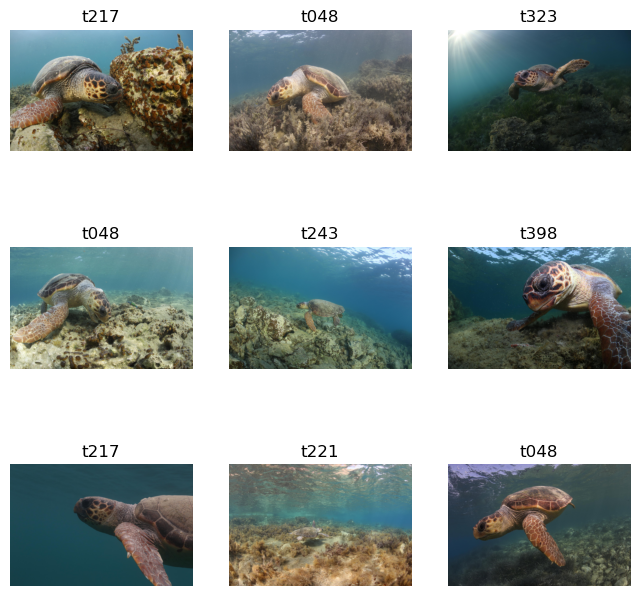

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label, text_label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(text_label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()